### Курсовой проект по курсу "PyTorch для разработки искусственных нейронных сетей"

In [1]:
import numpy as np
import cv2
import face_recognition
from IPython.display import Image

In [2]:
cv2.__version__

'4.4.0'

#### Cчитывание и вывод кадров с веб-камеры. Определение человека перед камерой.

In [3]:
def grayscale(image):
    # Convert image to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return img_gray

In [4]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
cap.set(3, 640) # set Width
cap.set(4, 480) # set Height
font = cv2.FONT_HERSHEY_DUPLEX

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )

    # top, right, bottom, left
    for (x, y, w, h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        cv2.putText(img, 'Igor', (x+4,y+h-4), font, 0.5, (255, 255, 255), 1)        

    cv2.imshow('Live Face detection', img)

    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
# Результат до нажатия клавиши "Escape"
Image(url= "FaceDetect.png")

### Разработка модели для распознавания жестов

#### На основе датасета  https://www.kaggle.com/gti-upm/leapgestrecog

In [7]:
import os
from PIL import Image 

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
# Словарь меток классов
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('leapGestRecog/00/'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [10]:
# Подготовка данных для обучения в виде numpy-массивов
x_data = []
y_data = []
datacount = 0
for i in range(0, 10):
    for j in os.listdir('leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'):
            count = 0
            for k in os.listdir('leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                img = Image.open('leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                img = img.resize((160, 60))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count

x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

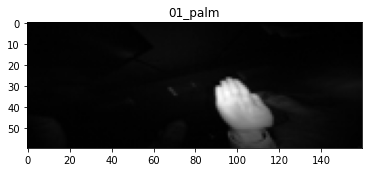

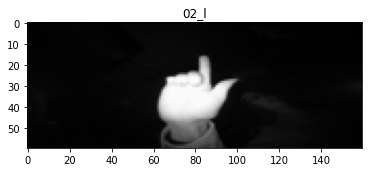

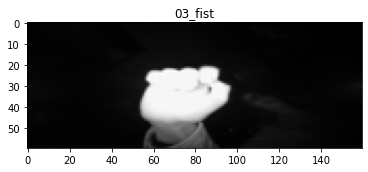

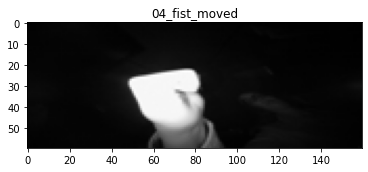

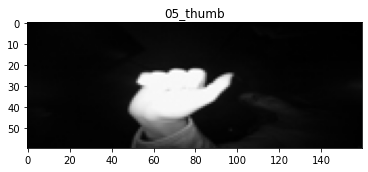

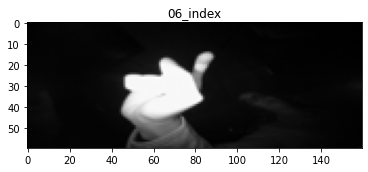

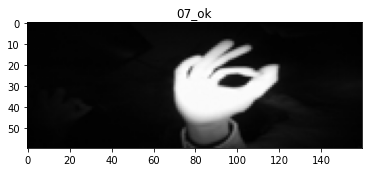

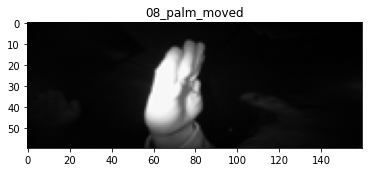

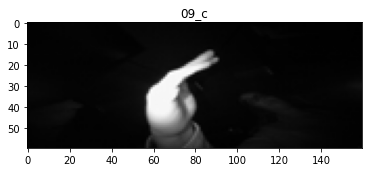

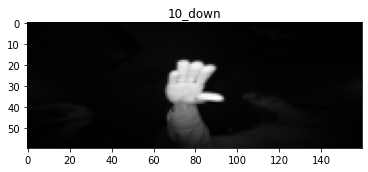

In [11]:
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :], cmap='gray')
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

In [12]:
class Hand_Dataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data) 
    
    def __getitem__(self, idx):
        item = torch.Tensor(self.x_data[idx].reshape(-1, 60, 160))
        label = self.y_data[idx,0]

        return (item, label)

In [41]:
dataset = Hand_Dataset(x_data, y_data)

In [42]:
train_loader = DataLoader(dataset, batch_size = 10, shuffle=True)

In [43]:
i, j = next(iter(train_loader))
print('Image shape:', i.size())
print('Label shape:', j.size())
print('Label:', j)

Image shape: torch.Size([10, 1, 60, 160])
Label shape: torch.Size([10])
Label: tensor([4, 5, 9, 0, 5, 0, 9, 2, 5, 6], dtype=torch.int32)


In [44]:
# Модель свёрточной сети для распознавания жестов
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*2*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)   

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64*2*8)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

net = Net().to(device)

In [45]:
# Обучение нейросети
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

for epoch in range(13):  
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item() 

    print(f'Epoch: {epoch:2d}, Loss: {running_loss:.6f}')  

Epoch:  0, Loss: 247.810051
Epoch:  1, Loss: 25.788586
Epoch:  2, Loss: 34.338119
Epoch:  3, Loss: 25.814847
Epoch:  4, Loss: 11.358688
Epoch:  5, Loss: 0.014791
Epoch:  6, Loss: 0.002731
Epoch:  7, Loss: 0.001296
Epoch:  8, Loss: 0.000551
Epoch:  9, Loss: 0.000214
Epoch: 10, Loss: 0.000084
Epoch: 11, Loss: 0.000029
Epoch: 12, Loss: 0.000010


#### Проверка предсказаний нейросети на моих фото

01_palm


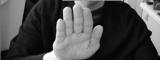

In [46]:
img = Image.open('My_Palm.png').convert('L')
img = img.resize((160, 60))
img_t = torch.Tensor(np.array(img))
img_t = img_t.unsqueeze(0).unsqueeze(0)

net = net.to('cpu')
output = net(img_t)

_, predicted = torch.max(output,1)

print(reverselookup[predicted[0].item()])
img

img_t = torch.Size([60, 160])
07_ok


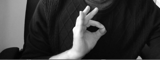

In [47]:
img = Image.open('My_OK.png').convert('L')
img = img.resize((160, 60))
img_t = torch.Tensor(np.array(img))
print(f'img_t = {img_t.shape}')
img_t = img_t.unsqueeze(0).unsqueeze(0)

net = net.to('cpu')
output = net(img_t)

_, predicted = torch.max(output,1)

print(reverselookup[predicted[0].item()])
img

In [48]:
print(f'img   = {np.array(img).shape}')
print(f'img_t = {img_t.shape}')

img   = (60, 160)
img_t = torch.Size([1, 1, 60, 160])


### Определение лица и распознавание жестов на Web-камере.

In [49]:
width  = 640  # Определяем ширину
height = 480  # Определяем высоту

cap = cv2.VideoCapture(0)
cap.set(3, width) # set Width
cap.set(4, height) # set Height
font = cv2.FONT_HERSHEY_DUPLEX

while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )
    
    # Область для распознавания жестов
    img2 = grayscale(img[int(height*0.6):height, 0:width-80])
    img2 = cv2.resize(img2, (160, 60), interpolation = cv2.INTER_AREA)
    img_t = torch.Tensor(np.array(img2))
    img_t = img_t.unsqueeze(0).unsqueeze(0)
    net = net.to('cpu')
    output = net(img_t)
    _, predicted = torch.max(output, 1)

    x1, x2, y1, y2 = 0, 560, int(height*0.6), height
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
    cv2.putText(img, reverselookup[predicted[0].item()], (x1+10, y1+20), font, 1, (255, 255, 255), 1)

    # Распознавание лица
    # top, right, bottom, left
    for (x, y, w, h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        cv2.putText(img, 'Igor', (x+4,y+h-4), font, 0.5, (255, 255, 255), 1)        

    #cv2.imshow('Live Face detection', grayscale(img))
    cv2.imshow('Live Face detection', img)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break

cap.release()
cv2.destroyAllWindows()

In [52]:
from IPython.display import Image
Image(url= "Result_OK.png")

#### Нейросеть правильно распознала жест и вывела соответствующую надпись: "07_ok"